# Example notebook using Qililab

In [1]:
import os
from pathlib import Path

import numpy as np
from qibo.gates import M, X
from qibo.models.circuit import Circuit
from qiboconnection.api import API, ConnectionConfiguration

import qililab as ql

%matplotlib widget

In [2]:
fname = os.path.abspath("")
os.environ["RUNCARDS"] = str(Path(fname) / "runcards")
os.environ["DATA"] = str(Path(fname) / "data")

## Load a platform

In [3]:
runcard_name = "galadriel"
platform = ql.build_platform(name=runcard_name)

[qililab] [0.16.1|INFO|2023-05-22 20:31:32]: Building platform
INFO:qililab.config.config:Building platform
[qililab] [0.16.1|WARNING|2023-05-22 20:31:32]: Cannot set `output_i=1` and `output_q=0` in hardware. The I/Q signals sent to sequencer 1 will be swapped to allow this setting.
[qililab] [0.16.1|WARNING|2023-05-22 20:31:32]: Cannot set `output_i=3` and `output_q=2` in hardware. The I/Q signals sent to sequencer 3 will be swapped to allow this setting.


### Platform Chip

In [4]:
print(platform.chip)

Chip None with 10 qubits and 12 ports: 

 * Port 10: ----|qubit_0|----
 * Port 11: ----|qubit_1|----
 * Port 12: ----|qubit_2|----
 * Port 13: ----|qubit_3|----
 * Port 14: ----|qubit_4|----
 * Port 15: ----|qubit_5|----
 * Port 16: ----|qubit_6|----
 * Port 17: ----|qubit_7|----
 * Port 18: ----|qubit_8|----
 * Port 19: ----|qubit_9|----
 * Port 100: ----|resonator_q0|--|resonator_q1|--|resonator_q2|--|resonator_q3|--|resonator_q4|----
 * Port 101: ----|resonator_q0|--|resonator_q1|--|resonator_q2|--|resonator_q3|--|resonator_q4|----



### Platform Buses

In [5]:
print(platform.schema)

Bus 0:  -----|QRM1|--|rs_1|------|resonator_q0|------|resonator_q1|------|resonator_q2|------|resonator_q3|------|resonator_q4|----
Bus 10:  -----|QCM-RF1|------|qubit_0|----
Bus 15:  -----|QCM1|------|qubit_5|----
Bus 11:  -----|QCM-RF1|------|qubit_1|----
Bus 16:  -----|QCM1|------|qubit_6|----
Bus 12:  -----|QCM-RF3|------|qubit_2|----
Bus 17:  -----|QCM2|------|qubit_7|----
Bus 13:  -----|QCM-RF2|------|qubit_3|----
Bus 18:  -----|QCM1|------|qubit_8|----
Bus 14:  -----|QCM-RF2|------|qubit_4|----
Bus 19:  -----|QCM1|------|qubit_9|----


## Connect to a Platform

In [ ]:
# Connect to all instruments of the platform and block the connection for other users
platform.connect(manual_override=False)  # if manual_override=True, it surpasses any blocked connection
platform.initial_setup()  # Sets all the values of the Runcard to the connected instruments
platform.turn_on_instruments()  # Turns on all instruments

## Create an experiment

### Create the circuit associated with the experiment

In [10]:
# Define Circuit to execute
circuit = Circuit(2)
circuit.add(ql.Drag(q=0, theta=1.23, phi=4.56))
circuit.add(ql.Drag(q=1, theta=2, phi=3))
circuit.add(M(0))

MeasurementResult(qubits=(0,), nshots=0)

### Create loops over parameter values (optional)

In [11]:
lo_freq_loop = ql.Loop(
    alias="drive_line_bus",
    parameter=ql.Parameter.LO_FREQUENCY,
    values=np.linspace(start=6.0e09, stop=6.5e09, num=10),
)

### Initialize the Experiment

In [12]:
settings = ql.ExperimentSettings(
    hardware_average=1000,
    repetition_duration=200_000,
    software_average=1,
)

options = ql.ExperimentOptions(
    loops=[lo_freq_loop],  # loops to run the experiment
    settings=settings,  # experiment settings
    name="experiment_name",  # name of the experiment (it will be also used for the results folder name)
)

sample_experiment = ql.Experiment(
    platform=platform,  # platform to run the experiment
    circuits=[circuit],  # circuits to run the experiment
    options=options,  # experiment options
)

### Translate the circuit into pulses and build the Execution object

In [13]:
sample_experiment.build_execution()

### Draw pulses to be sent

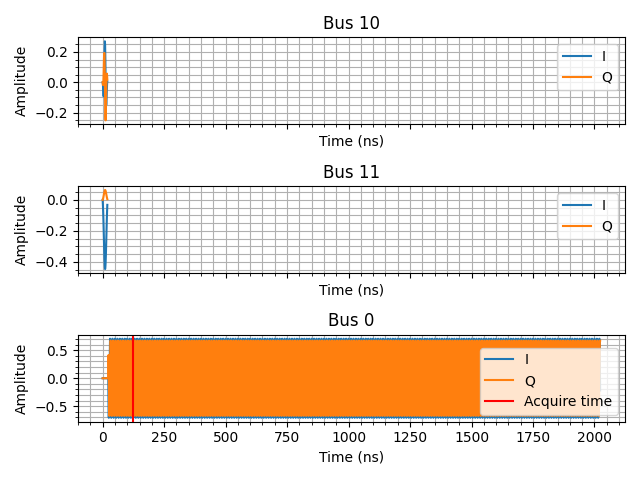

In [14]:
figure = sample_experiment.draw()

## Check the compiled sequences of the experiment

In [15]:
# this method compiles the pulses into the assembly program and returns all the sequences sent to the instruments
sequences = sample_experiment.compile()

[qililab] [0.16.1|INFO|2023-05-22 20:32:57]: Q1ASM program: 
 setup:
    move             1000, R0
    wait_sync        4
    
average:
    reset_ph
    set_awg_gain     12828, 12828
    set_ph           12666666
    play             0, 1, 4
    long_wait_1:
        move             3, R1
        long_wait_1_loop:
            wait             65532
            loop             R1, @long_wait_1_loop
        wait             3400
        
    loop             R0, @average
stop:
    stop
    

INFO:qililab.config.config:Q1ASM program: 
 setup:
    move             1000, R0
    wait_sync        4
    
average:
    reset_ph
    set_awg_gain     12828, 12828
    set_ph           12666666
    play             0, 1, 4
    long_wait_1:
        move             3, R1
        long_wait_1_loop:
            wait             65532
            loop             R1, @long_wait_1_loop
        wait             3400
        
    loop             R0, @average
stop:
    stop
    

[qililab] [0.16.1|INFO|202

Program of the drive line bus:

In [16]:
sequences[0]["drive_line_q0_bus"][0]._program

setup:
    move             1000, R0
    wait_sync        4
    
average:
    reset_ph
    set_awg_gain     12828, 12828
    set_ph           12666666
    play             0, 1, 4
    long_wait_1:
        move             3, R1
        long_wait_1_loop:
            wait             65532
            loop             R1, @long_wait_1_loop
        wait             3400
        
    loop             R0, @average
stop:
    stop
    

Program of the feedline input output bus:

In [17]:
sequences[0]["feedline_bus"][0]._program

setup:
    move             1000, R0
    wait_sync        4
    
average:
    wait             24
    reset_ph
    set_awg_gain     32767, 32767
    set_ph           0
    play             0, 1, 4
    acquire          0, 0, 4
    long_wait_3:
        move             3, R1
        long_wait_3_loop:
            wait             65532
            loop             R1, @long_wait_3_loop
        wait             3372
        
    loop             R0, @average
stop:
    stop
    

## Run the experiment

In [ ]:
results = sample_experiment.run()

In [ ]:
print(results)

## Disconnect from a Platform

- Disconnect all instruments specified in the loaded platform
- Turns off the instruments only when explicitly specified (by default is set to False)

In [ ]:
platform.disconnect()

[qibo-connection] 0.7.2|INFO|2023-03-23 12:44:08]: Device Galadriel Qblox rack released.
INFO:qiboconnection.config:Device Galadriel Qblox rack released.
[qililab] [0.16.1|INFO|2023-03-23 12:44:08]: Already disconnected from the instruments
INFO:qililab.config.config:Already disconnected from the instruments
